# Práctica 7: Detección de Objetos

In [1]:
import torch
import cv2 as cv
from matplotlib import pyplot as plt
from multihands import MultiHandTracker
from handperson import HandPerson
from ultralytics import YOLO

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## 1. Seguimiento de una persona

In [4]:
video = cv.VideoCapture("../videos/people2.mp4")
fps = video.get(cv.CAP_PROP_FPS)

status, img = video.read()
size=(img.shape[1], img.shape[0])

fourcc = cv.VideoWriter_fourcc(*'DIVX')
video_out = cv.VideoWriter('videos/video1.mp4', fourcc, 20.0, size)

model = YOLO('./models/yolo11x-pose.pt')

person = HandPerson(fps=fps)
pos_person = 3
i = 0

while status:
    orig = img.copy()
    original = img.copy()
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    detections = model(img)

    if i < 1:
        keypoints = detections[0].keypoints
        keypoint = keypoints[pos_person]
        keypoint_coordinates = keypoint.xy[0]
        right_wrists = keypoint_coordinates[10]
        person.add(int(right_wrists[0]), int(right_wrists[1]))
    else:
        keypoints = detections[0].keypoints

        for keypoint in keypoints:
            keypoint_coordinates = keypoint.xy[0]
            right_wrists = keypoint_coordinates[10]
            conf = keypoint.conf[0, 10]
            if conf > 0.5:
                x, y = int(right_wrists[0]), int(right_wrists[1])
                w, h = 10, 10
                cv.rectangle(img, (x - w // 2, y - h // 2), (x + w // 2, y + h // 2), (0, 255, 0))
                person.calculate_distance(int(right_wrists[0]), int(right_wrists[1]))
    
    for j in range(1, len(person.x)):
        if person.x[j - 1] is not None and person.x[j] is not None:
            cv.line(img, 
                    (person.x[j - 1], person.y[j - 1]), 
                    (person.x[j], person.y[j]), 
                    (255, 0, 0), 
                    2)
    
    i += 1
    
    cv.imshow('Tracking', img)
    
    status, img = video.read()
    
    if cv.waitKey(1)==27:
        status = False
    
video.release()
video_out.release()
cv.destroyAllWindows()

100%|██████████| 113M/113M [00:03<00:00, 38.5MB/s] 



0: 384x640 7 persons, 803.0ms
Speed: 19.3ms preprocess, 803.0ms inference, 22.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 721.4ms
Speed: 3.0ms preprocess, 721.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 683.9ms
Speed: 2.0ms preprocess, 683.9ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 880.1ms
Speed: 2.2ms preprocess, 880.1ms inference, 6.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 694.5ms
Speed: 2.0ms preprocess, 694.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 693.2ms
Speed: 3.0ms preprocess, 693.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 628.3ms
Speed: 2.0ms preprocess, 628.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 624.5ms
Speed: 2.0ms preprocess, 624.5ms inference, 1.0ms postprocess pe

### Gráficas

AttributeError: 'HandPerson' object has no attribute 'velocities'

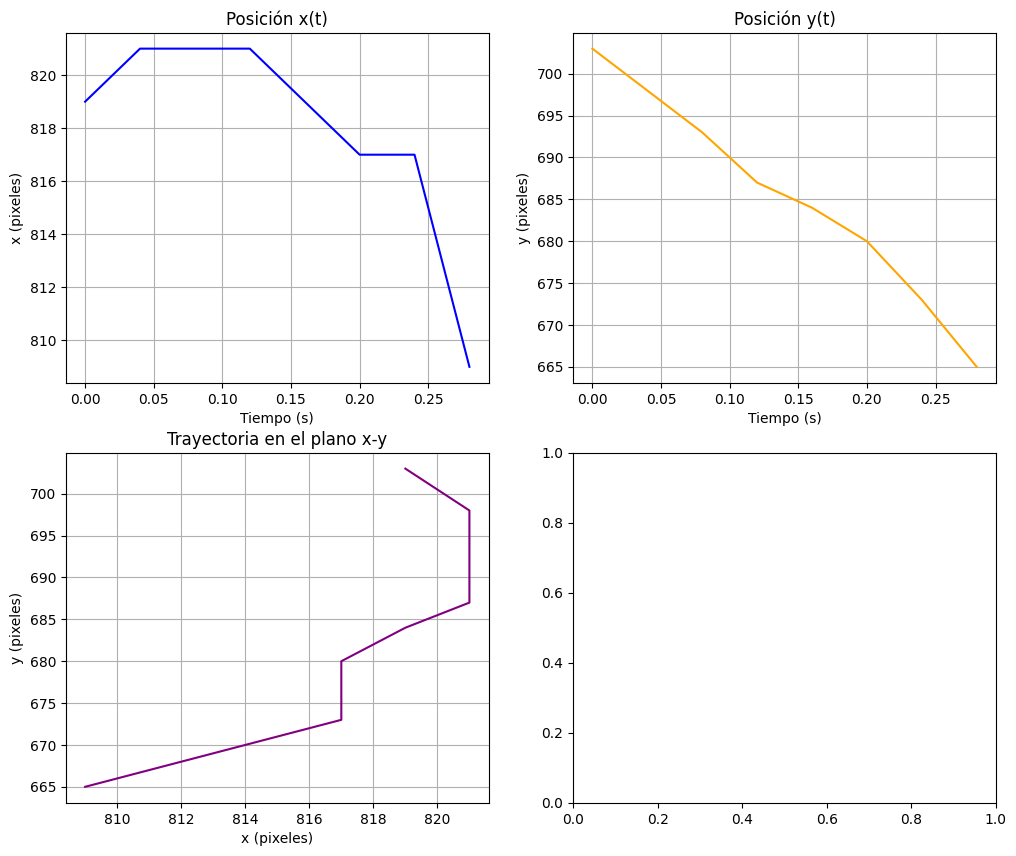

In [5]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(person.timestamps, person.x, label="x(t)", color="blue")
plt.xlabel("Tiempo (s)")
plt.ylabel("x (pixeles)")
plt.title("Posición x(t)")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(person.timestamps, person.y, label="y(t)", color="orange")
plt.xlabel("Tiempo (s)")
plt.ylabel("y (pixeles)")
plt.title("Posición y(t)")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(person.x, person.y, label="Trayectoria", color="purple")
plt.xlabel("x (pixeles)")
plt.ylabel("y (pixeles)")
plt.title("Trayectoria en el plano x-y")
plt.grid()

plt.subplot(2, 2, 4)
if person.velocities:
    plt.plot(person.timestamps[1:], person.velocities, label="v(t)", color="green")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (pixeles/s)")
plt.title("Velocidad v(t)")
plt.grid()

plt.tight_layout()
plt.show()

## 2. Seguimiento de varias personas

In [3]:
video = cv.VideoCapture("videos/people2.mp4")
fps = video.get(cv.CAP_PROP_FPS)

status, img = video.read()
size=(img.shape[1], img.shape[0])

fourcc = cv.VideoWriter_fourcc(*'DIVX')
video_out = cv.VideoWriter('videos/video2.mp4', fourcc, 20.0, size)

model = YOLO('./models/yolo11x-pose.pt')


multi_tracker = MultiHandTracker(fps=fps)

while status:
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    detections = model(img)

    if len(detections) > 0:
        keypoints = detections[0].keypoints
        multi_tracker.update(keypoints)

    for hand in multi_tracker.tracked_hands:
        if len(hand.x) > 0:
            x, y = hand.x[-1], hand.y[-1]
            w, h = 10, 10
            cv.rectangle(img, (x - w // 2, y - h // 2), (x + w // 2, y + h // 2), (0, 255, 0))
        for j in range(1, len(hand.x)):
            if hand.x[j - 1] is not None and hand.x[j] is not None:
                cv.line(
                    img, 
                    (hand.x[j - 1], hand.y[j - 1]), 
                    (hand.x[j], hand.y[j]), 
                    (255, 0, 0), 
                    2
                )
    
    cv.imshow('Tracking', img)

    video_out.write(cv.cvtColor(img, cv.COLOR_RGB2BGR))
    
    status, img = video.read()
    if cv.waitKey(1) == 27:
        break
    
video.release()
video_out.release()
cv.destroyAllWindows()


0: 384x640 7 persons, 564.3ms
Speed: 2.7ms preprocess, 564.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 574.4ms
Speed: 2.0ms preprocess, 574.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 541.5ms
Speed: 1.0ms preprocess, 541.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 538.7ms
Speed: 1.0ms preprocess, 538.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 542.8ms
Speed: 1.0ms preprocess, 542.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 616.1ms
Speed: 1.0ms preprocess, 616.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 547.6ms
Speed: 2.0ms preprocess, 547.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 545.6ms
Speed: 2.5ms preprocess, 545.6ms inference, 1.0ms postprocess per 